Cell 0 — Install packages

In [1]:
# Install required packages (run once)
%pip install -q mne PyWavelets scikit-learn seaborn
%pip install -q imbalanced-learn
%pip install -q azureml-core azure-ai-ml azure-identity

print("✅ Packages installed (if no errors above).")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
✅ Packages installed (if no errors above).


Cell 1 — Load libraries + set seeds

In [2]:
import os  # file/folder ops
import random  # python RNG
import numpy as np  # arrays/math

import mne  # EEG reading/processing
import pywt  # wavelets
from sklearn.decomposition import FastICA  # ICA
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score  # metrics
from sklearn.model_selection import StratifiedKFold  # 10-fold CV

from collections import defaultdict  # grouping
from typing import Optional, Union, Sequence, Dict, Tuple, List  # typing helpers

import matplotlib.pyplot as plt  # plotting
import seaborn as sns  # heatmaps

import tensorflow as tf  # tensorflow
from tensorflow.keras.models import Model  # keras model
from tensorflow.keras.layers import (  # layers
    Conv2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization,
    Input, DepthwiseConv2D, SeparableConv2D, Activation
)
from tensorflow.keras.optimizers import Adam  # optimizer
from tensorflow.keras.losses import BinaryCrossentropy  # loss
from tensorflow.keras.metrics import BinaryAccuracy  # metric
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger  # callbacks

from imblearn.over_sampling import SMOTE, RandomOverSampler  # SMOTE + fallback oversampler

# Try enabling interactive logging (optional)
try:
    tf.keras.utils.enable_interactive_logging()  # better logs if supported
except Exception:
    pass  # ignore if unsupported

# Set seeds for reproducibility
random.seed(42)  # python seed
np.random.seed(42)  # numpy seed
tf.random.set_seed(42)  # TF seed

print("✅ Imports done + seeds set.")  # progress print


2026-01-09 03:41:48.949799: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-09 03:41:49.248646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767930109.354296    3126 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767930109.382802    3126 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767930109.622506    3126 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

✅ Imports done + seeds set.


Cell 2 — Helper: load EEG (.set) with labels

In [3]:
def load_eeg_data_with_target(  # loader function
    folder_path: str,  # folder containing .set
    session_name: str,  # ses-1 or ses-2
    max_samples: int = 118000,  # max keep from start
    discard_samples: int = 10000  # discard beginning
):
    """Load EEG data from .set files and assign labels based on session_name."""  # docstring

    eeg_files = [f for f in os.listdir(folder_path) if f.endswith('.set')]  # list .set files
    data_list = []  # store arrays
    targets = []  # store labels
    sfreq_list = []  # store sampling rates

    for eeg_file in eeg_files:  # loop files
        file_path = os.path.join(folder_path, eeg_file)  # full path

        raw = mne.io.read_raw_eeglab(file_path, preload=True, verbose=False)  # read file
        data = raw.get_data().astype(np.float32)  # (C,T)
        sfreq = float(raw.info["sfreq"])  # sampling rate

        if data.shape[1] > max_samples:  # trim if too long
            data = data[:, :max_samples]  # keep first max

        if data.shape[1] > discard_samples:  # ensure can discard
            data = data[:, discard_samples:]  # discard start
        else:
            print(f"⚠️ Not enough samples to discard in {eeg_file}, skipping.")  # warn
            continue  # skip

        data_list.append(data)  # save data
        sfreq_list.append(sfreq)  # save fs

        if session_name == 'ses-1':  # session 1 label
            targets.append(0)  # class 0
        elif session_name == 'ses-2':  # session 2 label
            targets.append(1)  # class 1
        else:
            print(f"⚠️ Unknown session name: {session_name}")  # warn

    return data_list, targets, sfreq_list  # return


Cell 3 — Leakage-safe preprocessing classes

In [4]:
def _names_from_index_mapping(  # helper
    n_channels: int,  # number of channels
    index_to_name: Optional[Dict[int, str]]  # optional mapping
) -> List[str]:
    """Map numeric channel indices to names or auto-name."""  # docstring

    if index_to_name is None:  # if no mapping
        return [f"EEG{i+1}" for i in range(n_channels)]  # auto names

    keys = list(index_to_name.keys())  # mapping keys
    is_zero_based = (0 in keys) and (1 not in keys)  # detect 0-based mapping

    names = []  # output names
    for i in range(n_channels):  # for each channel
        key = i if is_zero_based else (i + 1)  # choose key style
        names.append(index_to_name.get(key, f"EEG{i+1}"))  # mapped or fallback
    return names  # return names


def _make_raw(  # helper
    eeg: np.ndarray,  # eeg array
    sfreq: float,  # sampling frequency
    ch_names: List[str],  # channel names
    use_standard_1020: bool = True  # montage flag
) -> Tuple[mne.io.Raw, bool]:
    """Create MNE Raw and optionally apply 10-20 montage."""  # docstring

    ch_types = ['eog' if str(n).upper().startswith("EOG") else 'eeg' for n in ch_names]  # guess types
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)  # info
    raw = mne.io.RawArray(eeg.astype(np.float32, copy=False), info, verbose=False)  # raw object

    montage_applied = False  # flag

    if use_standard_1020:  # if apply montage
        try:
            mont = mne.channels.make_standard_montage("standard_1020")  # load montage
            raw.set_montage(mont, match_case=False, on_missing="ignore")  # apply montage
            montage_applied = True  # mark ok
        except Exception:
            montage_applied = False  # mark fail

    return raw, montage_applied  # return raw + flag


class WaveletICA:
    """Wavelet-enhanced ICA (wICA)."""  # docstring
    def __init__(self, wavelet="db4", level=3, n_components=10, random_state=42):  # init
        self.wavelet = wavelet  # wavelet
        self.level = level  # level
        self.n_components = n_components  # ICA comps
        self.random_state = random_state  # seed
        self.ica_: Optional[FastICA] = None  # fitted ICA
        self._n_ch: Optional[int] = None  # channel count

    def fit(self, X: np.ndarray):  # fit
        C = X.shape[0]  # channels
        self._n_ch = C  # store channels

        coeffs = pywt.wavedec(X, wavelet=self.wavelet, level=self.level, axis=1)  # DWT
        A = coeffs[0]  # approximation

        k = int(min(self.n_components, C))  # clip comps
        self.ica_ = FastICA(n_components=k, random_state=self.random_state)  # ICA model

        S = self.ica_.fit_transform(A.T)  # fit ICA
        A_denoised = self.ica_.inverse_transform(S).T  # inverse ICA

        coeffs[0] = A_denoised  # replace approx
        _ = pywt.waverec(coeffs, wavelet=self.wavelet, axis=1)  # sanity reconstruction

        return self  # return self

    def transform(self, X: np.ndarray) -> np.ndarray:  # transform
        assert self.ica_ is not None, "WaveletICA not fitted yet."  # ensure fit

        coeffs = pywt.wavedec(X, wavelet=self.wavelet, level=self.level, axis=1)  # DWT
        A = coeffs[0]  # approximation

        S = self.ica_.transform(A.T)  # project
        A_denoised = self.ica_.inverse_transform(S).T  # reconstruct

        coeffs[0] = A_denoised  # replace
        Y = pywt.waverec(coeffs, wavelet=self.wavelet, axis=1)  # full recon

        if Y.shape[1] < X.shape[1]:  # pad if short
            pad_width = X.shape[1] - Y.shape[1]  # pad amount
            Y = np.pad(Y, ((0, 0), (0, pad_width)), mode="constant")  # pad
        elif Y.shape[1] > X.shape[1]:  # trim if long
            Y = Y[:, :X.shape[1]]  # trim

        return Y.astype(np.float32, copy=False)  # return float32


class EEGPreprocessor:
    """Leakage-safe preprocessing class (as you provided)."""  # docstring
    def __init__(
        self,
        *,
        index_to_name: Optional[Dict[int, str]] = None,
        use_standard_1020: bool = True,
        resample_to: Optional[float] = None,
        notch_freqs: Union[None, float, Sequence[float]] = 50.0,
        highpass: Optional[float] = 0.05,
        bad_point_z: float = 6.0,
        bad_channel_z: float = 5.0,
        interpolate_bad_channels: bool = False,
        car: bool = True,
        use_wica: bool = True,
        wica_components: int = 10,
        wica_wavelet: str = "db4",
        wica_level: int = 3,
        wica_random_state: int = 42
    ):
        self.index_to_name = index_to_name
        self.use_standard_1020 = use_standard_1020
        self.resample_to = resample_to
        self.notch_freqs = notch_freqs
        self.highpass = highpass
        self.bad_point_z = bad_point_z
        self.bad_channel_z = bad_channel_z
        self.interpolate_bad_channels = interpolate_bad_channels
        self.car = car
        self.use_wica = use_wica

        self._sfreq_out: Optional[float] = None
        self._train_mu: Optional[np.ndarray] = None
        self._train_sd: Optional[np.ndarray] = None
        self._robust_med: Optional[float] = None
        self._robust_mad: Optional[float] = None
        self._train_eeg_names: Optional[List[str]] = None

        self._wica = WaveletICA(
            wavelet=wica_wavelet,
            level=wica_level,
            n_components=wica_components,
            random_state=wica_random_state
        )

    @property
    def sfreq_out(self) -> float:
        assert self._sfreq_out is not None, "Preprocessor not run yet."
        return float(self._sfreq_out)

    def _filter_and_reference(self, raw: mne.io.Raw):
        if self.resample_to is not None and float(self.resample_to) != float(raw.info["sfreq"]):
            raw.resample(self.resample_to, npad="auto")

        self._sfreq_out = float(raw.info["sfreq"])

        if self.notch_freqs is not None:
            raw.notch_filter(freqs=self.notch_freqs, verbose=False)

        if self.highpass is not None:
            raw.filter(l_freq=self.highpass, h_freq=None, verbose=False)

        if self.car:
            raw.set_eeg_reference("average", projection=True)
            raw.apply_proj()

    def _repair_transients_with_train_stats(self, raw: mne.io.Raw):
        X = raw.get_data()
        mu = self._train_mu
        sd = self._train_sd
        assert mu is not None and sd is not None, "Training stats not set."

        hi = mu + self.bad_point_z * sd
        lo = mu - self.bad_point_z * sd
        mask = (X > hi) | (X < lo)

        if np.any(mask):
            X_fixed = X.copy()
            t = np.arange(X.shape[1], dtype=float)
            for ch in range(X.shape[0]):
                m = mask[ch]
                if m.any():
                    good = ~m
                    if good.sum() >= 2:
                        X_fixed[ch, m] = np.interp(t[m], t[good], X_fixed[ch, good])
            raw._data = X_fixed

    def _interpolate_bad_channels_with_train_calibration(self, raw: mne.io.Raw):
        if not self.interpolate_bad_channels:
            return

        picks = mne.pick_types(raw.info, eeg=True)
        if len(picks) == 0:
            return

        X = raw.get_data(picks=picks)
        ch_std = X.std(axis=1)

        med = self._robust_med
        mad = self._robust_mad
        if med is None or mad is None or mad == 0:
            return

        z = 0.6745 * (ch_std - med) / mad
        eeg_names = mne.pick_info(raw.info, picks).ch_names
        bads = [eeg_names[i] for i in np.where(np.abs(z) > self.bad_channel_z)[0]]

        raw.info["bads"] = bads
        if bads:
            raw.interpolate_bads(reset_bads=True, verbose=False)

    def fit(self, X_train: np.ndarray, sfreq: float):
        C = X_train.shape[0]
        ch_names = _names_from_index_mapping(C, self.index_to_name)

        raw_train, montage_applied = _make_raw(X_train, sfreq, ch_names, self.use_standard_1020)
        self._filter_and_reference(raw_train)

        Xt = raw_train.get_data()
        self._train_mu = Xt.mean(axis=1, keepdims=True)
        self._train_sd = Xt.std(axis=1, keepdims=True) + 1e-12

        if montage_applied:
            picks_eeg = mne.pick_types(raw_train.info, eeg=True)
            if len(picks_eeg):
                X_eeg = Xt[picks_eeg]
                ch_std = X_eeg.std(axis=1)
                med = np.median(ch_std)
                mad = np.median(np.abs(ch_std - med)) + 1e-12
                self._robust_med = float(med)
                self._robust_mad = float(mad)
                self._train_eeg_names = mne.pick_info(raw_train.info, picks_eeg).ch_names
            else:
                self._robust_med = None
                self._robust_mad = None
        else:
            self._robust_med = None
            self._robust_mad = None

        self._repair_transients_with_train_stats(raw_train)
        Xt = raw_train.get_data()

        if montage_applied and self.interpolate_bad_channels:
            self._interpolate_bad_channels_with_train_calibration(raw_train)
            Xt = raw_train.get_data()

        if self.use_wica:
            self._wica.fit(Xt)

        return self

    def transform(self, X: np.ndarray, sfreq: float) -> Tuple[np.ndarray, float]:
        C = X.shape[0]
        ch_names = _names_from_index_mapping(C, self.index_to_name)

        raw, montage_applied = _make_raw(X, sfreq, ch_names, self.use_standard_1020)
        self._filter_and_reference(raw)
        self._repair_transients_with_train_stats(raw)

        if montage_applied and self.interpolate_bad_channels:
            self._interpolate_bad_channels_with_train_calibration(raw)

        Xf = raw.get_data()
        if self.use_wica:
            Xf = self._wica.transform(Xf)

        return Xf.astype(np.float32, copy=False), self.sfreq_out

    def fit_transform(self, X_train: np.ndarray, sfreq: float) -> Tuple[np.ndarray, float]:
        self.fit(X_train, sfreq)
        X_clean, fs_out = self.transform(X_train, sfreq)
        return X_clean, fs_out

print("✅ Preprocessing classes loaded.")  # progress print


✅ Preprocessing classes loaded.


Cell 4 — NEW dataset selection rule + Azure download + load raw EEG

In [5]:
from azureml.core import Workspace, Datastore  # azure workspace + datastore

print("[STEP 4] Connecting to Azure ML workspace...")  # progress print

# Workspace info (your values)
subscription_id = "eccc04ba-d8b0-4f70-864a-b4a6753bfc72"  # subscription
resource_group  = "somnasnest"  # RG
workspace_name  = "SomnasNest"  # workspace

ws = Workspace(  # connect
    subscription_id=subscription_id,  # sub id
    resource_group=resource_group,  # rg
    workspace_name=workspace_name  # ws name
)

print("[STEP 4] Getting datastore 'workspaceblobstore'...")  # progress print
datastore = Datastore.get(ws, "workspaceblobstore")  # blobstore

remote_prefix = "UI/2025-12-11_033542_UTC/New Dataset"  # remote folder inside datastore
local_root = "./azureml_eeg_data"  # local download root
os.makedirs(local_root, exist_ok=True)  # ensure folder exists

print(f"[STEP 4] Downloading datastore prefix: {remote_prefix}")  # progress print
n_files = datastore.download(  # download
    target_path=local_root,  # local target
    prefix=remote_prefix,  # remote prefix
    overwrite=False,  # don't overwrite
    show_progress=True,  # show progress
)
print(f"[STEP 4] Downloaded {n_files} file(s).")  # progress print

base_path = os.path.join(local_root, *remote_prefix.split("/"))  # local base path
print(f"[STEP 4] base_path = {base_path}")  # debug print

if not os.path.isdir(base_path):  # sanity check
    raise RuntimeError(f"[STEP 4] base_path does not exist: {base_path}")  # error

print("[STEP 4] Listing base_path contents:")  # progress print
print(os.listdir(base_path)[:10], "...")  # small preview

# ---------------- NEW SUBJECT/SESSION SELECTION RULE ----------------
# Rule:
#  - sub-01..sub-59 -> only ses-1 (class 0)
#  - sub-60..sub-71 -> only ses-2 (class 1)

sub_ses1 = [f"sub-{i:02d}" for i in range(1, 60)]  # sub-01..sub-59
sub_ses2 = [f"sub-{i:02d}" for i in range(60, 72)]  # sub-60..sub-71
subjects_used = sub_ses1 + sub_ses2  # full list

print("\n[STEP 4] Dataset rule summary:")  # progress print
print(f"  ses-1 subjects count: {len(sub_ses1)} (sub-01..sub-59)")  # summary
print(f"  ses-2 subjects count: {len(sub_ses2)} (sub-60..sub-71)")  # summary
print(f"  total subjects used : {len(subjects_used)}")  # summary

# Storage for raw trials
raw_list = []  # EEG trials
targets = []  # labels
sfreqs = []  # sampling rates
subject_ids = []  # subject id per trial

print("\n[STEP 4] Loading raw EEG data according to rule...")  # progress print

# Load ses-1 for sub-01..sub-59
for sub in sub_ses1:  # loop subjects
    session = "ses-1"  # only ses-1
    path = os.path.join(base_path, sub, session)  # folder path
    if not os.path.isdir(path):  # missing folder guard
        print(f"⚠️ Missing folder: {path}, skipping.")  # warn
        continue  # skip
    data_list, t_list, sf_list = load_eeg_data_with_target(path, session)  # load
    print(f"  Loaded {len(data_list)} trial(s) from {sub}/{session}")  # progress
    for data, t, sf in zip(data_list, t_list, sf_list):  # append
        raw_list.append(data.astype(np.float32, copy=False))  # store eeg
        targets.append(int(t))  # store label
        sfreqs.append(float(sf))  # store sf
        subject_ids.append(sub)  # store subject

# Load ses-2 for sub-60..sub-71
for sub in sub_ses2:  # loop subjects
    session = "ses-2"  # only ses-2
    path = os.path.join(base_path, sub, session)  # folder path
    if not os.path.isdir(path):  # missing folder guard
        print(f"⚠️ Missing folder: {path}, skipping.")  # warn
        continue  # skip
    data_list, t_list, sf_list = load_eeg_data_with_target(path, session)  # load
    print(f"  Loaded {len(data_list)} trial(s) from {sub}/{session}")  # progress
    for data, t, sf in zip(data_list, t_list, sf_list):  # append
        raw_list.append(data.astype(np.float32, copy=False))  # store eeg
        targets.append(int(t))  # store label
        sfreqs.append(float(sf))  # store sf
        subject_ids.append(sub)  # store subject

targets = np.array(targets, dtype=np.int32)  # labels to array
subject_ids = np.array(subject_ids)  # subject ids to array

print("\n[STEP 4] Finished loading raw trials.")  # progress print
print("  Total trials loaded:", len(raw_list))  # count
print("  Targets shape:", targets.shape)  # shape
print("  Unique labels + counts:", np.unique(targets, return_counts=True))  # label counts

# Sampling rate checks
sfreqs = np.array(sfreqs, dtype=np.float32)  # sf list to array
if len(sfreqs) == 0:  # guard
    raise RuntimeError("No EEG data found. Check paths / dataset.")  # error

fs = float(sfreqs[0])  # take first fs
if not np.allclose(sfreqs, fs):  # check consistency
    print("⚠️ Warning: Not all sampling frequencies are identical!")  # warn
print(f"[STEP 4] Using fs={fs} Hz")  # log


[STEP 4] Connecting to Azure ML workspace...
[STEP 4] Getting datastore 'workspaceblobstore'...
[STEP 4] Downloaded 0 file(s).
[STEP 4] base_path = ./azureml_eeg_data/UI/2025-12-11_033542_UTC/New Dataset
[STEP 4] Listing base_path contents:
['CHANGES', 'code', 'dataset_description.json', 'participants.json', 'participants.tsv', 'README', 'session_1_eeg_data.csv', 'session_2_eeg_data.csv', 'sub-01', 'sub-01_eeg_data.pkl'] ...

[STEP 4] Dataset rule summary:
  ses-1 subjects count: 59 (sub-01..sub-59)
  ses-2 subjects count: 12 (sub-60..sub-71)
  total subjects used : 71

[STEP 4] Loading raw EEG data according to rule...
  Loaded 1 trial(s) from sub-01/ses-1
  Loaded 1 trial(s) from sub-02/ses-1
  Loaded 1 trial(s) from sub-03/ses-1
  Loaded 1 trial(s) from sub-04/ses-1
  Loaded 1 trial(s) from sub-05/ses-1
  Loaded 1 trial(s) from sub-06/ses-1
  Loaded 1 trial(s) from sub-07/ses-1
  Loaded 1 trial(s) from sub-08/ses-1
  Loaded 1 trial(s) from sub-09/ses-1
  Loaded 1 trial(s) from sub-1

Path already exists. Skipping download for ./azureml_eeg_data/UI/2025-12-11_033542_UTC/New Dataset/session_1_eeg_data.csv
Path already exists. Skipping download for ./azureml_eeg_data/UI/2025-12-11_033542_UTC/New Dataset/session_2_eeg_data.csv
Path already exists. Skipping download for ./azureml_eeg_data/UI/2025-12-11_033542_UTC/New Dataset/sub-01/ses-1/sub-01_ses-1_task-eyesclosed_eeg.fdt
Path already exists. Skipping download for ./azureml_eeg_data/UI/2025-12-11_033542_UTC/New Dataset/sub-01/ses-1/sub-01_ses-1_task-eyesclosed_eeg.set
Path already exists. Skipping download for ./azureml_eeg_data/UI/2025-12-11_033542_UTC/New Dataset/sub-01/ses-2/sub-01_ses-2_task-eyesclosed_eeg.fdt
Path already exists. Skipping download for ./azureml_eeg_data/UI/2025-12-11_033542_UTC/New Dataset/sub-01/ses-2/sub-01_ses-2_task-eyesclosed_eeg.set
Path already exists. Skipping download for ./azureml_eeg_data/UI/2025-12-11_033542_UTC/New Dataset/sub-01_eeg_data.pkl
Path already exists. Skipping download fo

Cell 5 — Preprocess all trials

In [6]:
CHANNEL_MAP = None  # keep as before

pre = EEGPreprocessor(  # create preprocessor
    index_to_name=CHANNEL_MAP,  # channel map
    use_standard_1020=True,  # montage
    resample_to=None,  # no resample
    notch_freqs=[50.0, 100.0, 150.0],  # notch
    highpass=0.05,  # highpass
    bad_point_z=6.0,  # transient repair threshold
    bad_channel_z=5.0,  # bad channel threshold
    interpolate_bad_channels=False,  # disabled
    car=True,  # CAR
    use_wica=True,  # wICA on
    wica_components=10,  # comps
    wica_wavelet="db4",  # wavelet
    wica_level=3,  # level
    wica_random_state=42,  # seed
)

print("[STEP 5] Fitting EEGPreprocessor on a subset of loaded trials...")  # progress print

max_calib_trials = min(10, len(raw_list))  # same logic
if max_calib_trials == 0:  # guard
    raise RuntimeError("No data to fit EEGPreprocessor.")  # error

calib_trials = raw_list[:max_calib_trials]  # subset
X_calib = np.concatenate(calib_trials, axis=1).astype(np.float32, copy=False)  # concat time-wise

X_calib_clean, fs_out = pre.fit_transform(X_calib, fs)  # fit + transform
print(f"[STEP 5] Preprocessor fitted. Output fs: {fs_out} Hz")  # log

data_clean = []  # store cleaned trials
for i, segment in enumerate(raw_list):  # loop trials
    X_clean, _ = pre.transform(segment, fs)  # transform trial
    data_clean.append(X_clean.astype(np.float32, copy=False))  # store
    if (i + 1) % 20 == 0:  # periodic log
        print(f"[STEP 5] Preprocessed {i+1}/{len(raw_list)} trials")  # progress

data_clean = np.array(data_clean, dtype=np.float32)  # to array

print("[STEP 5] Done preprocessing all trials.")  # log
print("  data_clean shape:", data_clean.shape)  # shape
print("  targets shape   :", targets.shape)  # shape


[STEP 5] Fitting EEGPreprocessor on a subset of loaded trials...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
[STEP 5] Preprocessor fitted. Output fs: 500.0 Hz
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.

Cell 6 — Augmentation

In [7]:
def augment_data(data: np.ndarray, target: int, segment_size: int = 100):  # function
    """Split (C,T) trial into segments (C,segment_size) with same label."""  # docstring
    augmented_data = []  # segments
    augmented_targets = []  # labels

    if data.ndim == 3:  # if extra dim
        data = data[0]  # drop it

    n_segments = data.shape[1] // segment_size  # segment count

    for i in range(n_segments):  # loop segments
        seg = data[:, i * segment_size:(i + 1) * segment_size]  # slice
        augmented_data.append(seg.astype(np.float32, copy=False))  # save
        augmented_targets.append(int(target))  # save label

    return augmented_data, augmented_targets  # return

print("[STEP 6] Augmenting all trials...")  # log

augmented = []  # all segments
aug_targets = []  # segment labels
aug_subject_ids = []  # subject per segment

for trial, y, subj in zip(data_clean, targets, subject_ids):  # loop trials
    segs, ys = augment_data(trial, int(y), segment_size=100)  # segment
    augmented.extend(segs)  # add segments
    aug_targets.extend(ys)  # add labels
    aug_subject_ids.extend([subj] * len(segs))  # repeat subject id

augmented = np.array(augmented, dtype=np.float32)  # (N,C,Tseg)
aug_targets = np.array(aug_targets, dtype=np.int32)  # (N,)
aug_subject_ids = np.array(aug_subject_ids)  # (N,)

print("[STEP 6] Augmentation done.")  # log
print("  augmented shape:", augmented.shape)  # shape
print("  aug_targets shape:", aug_targets.shape)  # shape
print("  Class counts (augmented):", np.unique(aug_targets, return_counts=True))  # counts


[STEP 6] Augmenting all trials...
[STEP 6] Augmentation done.
  augmented shape: (76680, 61, 100)
  aug_targets shape: (76680,)
  Class counts (augmented): (array([0, 1], dtype=int32), array([63720, 12960]))


Cell 7 — “Fair selection” step

In [8]:
print("[STEP 7] Grouping segments by subject and class...")  # log

subject_data = defaultdict(lambda: {0: [], 1: []})  # subject -> {0:[...],1:[...]}

for x, y, subj in zip(augmented, aug_targets, aug_subject_ids):  # loop samples
    subject_data[subj][int(y)].append(x)  # store

max_per_class_per_subject = 200  # same parameter

selected_data = []  # selected samples
selected_targets = []  # selected labels

print("[STEP 7] Selecting up to 200 segments per (subject, class)...")  # log

for subj in subjects_used:  # loop all subjects in dataset
    for class_label in [0, 1]:  # loop both classes
        samples = subject_data.get(subj, {0: [], 1: []})[class_label]  # fetch
        picked = samples[:max_per_class_per_subject]  # take up to 200
        selected_data.extend(picked)  # add
        selected_targets.extend([class_label] * len(picked))  # add labels

selected_data = np.array(selected_data, dtype=np.float32)  # to array
selected_targets = np.array(selected_targets, dtype=np.int32)  # to array

print("[STEP 7] Selection done.")  # log
print("  selected_data shape:", selected_data.shape)  # shape
print("  selected_targets shape:", selected_targets.shape)  # shape
print("  Class counts (selected):", np.unique(selected_targets, return_counts=True))  # counts


[STEP 7] Grouping segments by subject and class...
[STEP 7] Selecting up to 200 segments per (subject, class)...
[STEP 7] Selection done.
  selected_data shape: (14200, 61, 100)
  selected_targets shape: (14200,)
  Class counts (selected): (array([0, 1], dtype=int32), array([11800,  2400]))


Cell 8 — Reshape for CNN

In [9]:
print("[STEP 8] Reshaping for CNN...")  # log

# (N,C,T) -> (N,C,T,1)
X_all = selected_data[..., np.newaxis].astype(np.float32, copy=False)  # CNN input
y_all = selected_targets.astype(np.int32, copy=False)  # labels

print("[STEP 8] Done.")  # log
print("  X_all shape:", X_all.shape)  # shape
print("  y_all shape:", y_all.shape)  # shape
print("  Class counts:", np.unique(y_all, return_counts=True))  # counts


[STEP 8] Reshaping for CNN...
[STEP 8] Done.
  X_all shape: (14200, 61, 100, 1)
  y_all shape: (14200,)
  Class counts: (array([0, 1], dtype=int32), array([11800,  2400]))


Cell 9 — EEGNet model

In [10]:
def get_lr(opt):  # helper
    """Safely read optimizer LR."""  # docstring
    try:
        return float(tf.keras.backend.get_value(opt.learning_rate))  # standard
    except Exception:
        try:
            return float(opt.learning_rate.numpy())  # alt
        except Exception:
            try:
                return float(opt.lr.numpy())  # legacy
            except Exception:
                return float(getattr(opt, "lr", 0.0))  # fallback

def create_eegnet(input_shape, dropout_rate=0.5, num_classes=1):  # EEGNet-ish
    """EEGNet (adapted to your pipeline)."""  # docstring
    n_electrodes = input_shape[0]  # channels
    inputs = Input(shape=input_shape)  # input

    x = Conv2D(16, (1, 64), padding='same', use_bias=False)(inputs)  # temporal conv
    x = BatchNormalization()(x)  # BN

    x = DepthwiseConv2D((n_electrodes, 1), depth_multiplier=2, padding='valid', use_bias=False)(x)  # spatial depthwise
    x = BatchNormalization()(x)  # BN
    x = Activation('elu')(x)  # ELU
    x = AveragePooling2D((1, 4))(x)  # pool
    x = Dropout(dropout_rate)(x)  # dropout

    x = SeparableConv2D(16, (1, 16), padding='same', use_bias=False)(x)  # separable conv
    x = BatchNormalization()(x)  # BN
    x = Activation('elu')(x)  # ELU
    x = AveragePooling2D((1, 8))(x)  # pool
    x = Dropout(dropout_rate)(x)  # dropout

    x = Flatten()(x)  # flatten
    x = Dense(64, activation='relu')(x)  # dense
    outputs = Dense(num_classes, activation='sigmoid')(x)  # sigmoid output

    return Model(inputs=inputs, outputs=outputs, name="EEGNet_simple")  # model

print("✅ Model function defined.")  # log


✅ Model function defined.


Cell 10 — NEW: 10-Fold CV + per-fold normalization + SMOTE + metrics + average

2026-01-09 03:44:44.294308: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "EEGNet_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 61, 100, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 61, 100, 16)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 61, 100, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 1, 100, 32)     │         1,952 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 100, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1, 100, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 25, 32)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 25, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 1, 25, 16)      │         1,024 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 25, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1, 25, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 1, 3, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,457 (29.13 KB)

 Trainable params: 7,329 (28.63 KB)

 Non-trainable params: 128 (512.00 B)

None
[FOLD 1] Training started...
Epoch 1/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.5848 - loss: 0.6747
Epoch 1: val_loss improved from inf to 0.65745, saving model to fold_01_best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 26s 253ms/step - accuracy: 0.5853 - loss: 0.6743 - val_accuracy: 0.7063 - val_loss: 0.6575 - learning_rate: 0.0010
Epoch 2/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.7490 - loss: 0.5149
Epoch 2: val_loss improved from 0.65745 to 0.59919, saving model to fold_01_best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 24s 249ms/step - accuracy: 0.7492 - loss: 0.5145 - val_accuracy: 0.7303 - val_loss: 0.5992 - learning_rate: 0.0010
Epoch 3/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.8294 - loss: 0.3903
Epoch 3: va

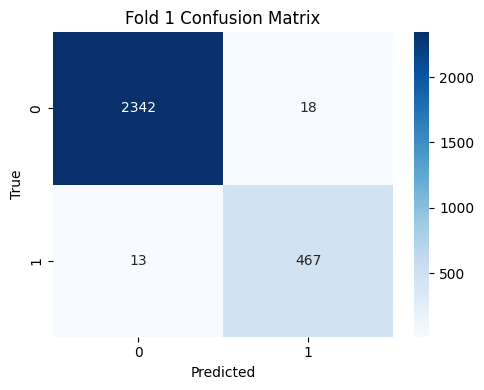

[FOLD 1] Metrics: acc=0.9891, prec=0.9629, rec=0.9729, spec=0.9924, f1=0.9679, auc=0.9963

[FOLD 2/5] Building fold data...
[FOLD 2] Train size: 11360 | Val size: 2840
[FOLD 2] Train class count (pre-balance): (array([0, 1], dtype=int32), array([9440, 1920]))
[FOLD 2] Val   class count:              (array([0, 1], dtype=int32), array([2360,  480]))
[FOLD 2] Computing normalization stats from TRAIN only...
[FOLD 2] ✅ Normalization done.
[FOLD 2] Preparing data for SMOTE (flatten to 2D)...
[FOLD 2] ✅ Class count BEFORE SMOTE: {0: 9440, 1: 1920}
[FOLD 2] ✅ SMOTE applied (k_neighbors=5).
[FOLD 2] ✅ Class count AFTER balancing (2D): {0: 9440, 1: 9440}
[FOLD 2] Reshaping back to CNN format...
[FOLD 2] ✅ Class count AFTER balancing (final): {0.0: 9440, 1.0: 9440}
[FOLD 2] X_train_bal shape: (18880, 61, 100, 1)
[FOLD 2] Building model...
[FOLD 2] Model compiled. Initial LR=0.0010000000474974513


Model: "EEGNet_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 61, 100, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 100, 16)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 61, 100, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 1, 100, 32)     │         1,952 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1, 100, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1, 100, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 1, 25, 32)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 25, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 1, 25, 16)      │         1,024 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 25, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1, 25, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 1, 3, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,457 (29.13 KB)

 Trainable params: 7,329 (28.63 KB)

 Non-trainable params: 128 (512.00 B)

None
[FOLD 2] Training started...
Epoch 1/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.5849 - loss: 0.6658
Epoch 1: val_loss improved from inf to 0.81447, saving model to fold_02_best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 27s 268ms/step - accuracy: 0.5855 - loss: 0.6654 - val_accuracy: 0.1926 - val_loss: 0.8145 - learning_rate: 0.0010
Epoch 2/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.7296 - loss: 0.5411
Epoch 2: val_loss did not improve from 0.81447
95/95 ━━━━━━━━━━━━━━━━━━━━ 25s 266ms/step - accuracy: 0.7298 - loss: 0.5409 - val_accuracy: 0.3063 - val_loss: 0.9172 - learning_rate: 0.0010
Epoch 3/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.8104 - loss: 0.4204
Epoch 3: val_loss improved from 0.81447 to 0.66694, savin

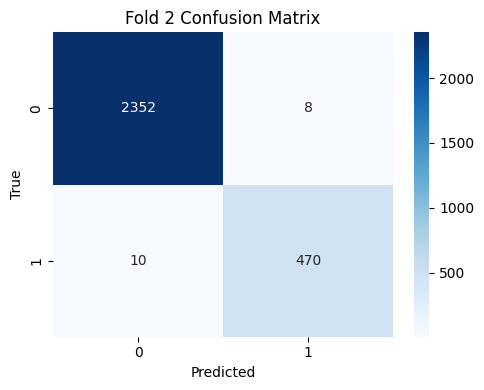

[FOLD 2] Metrics: acc=0.9937, prec=0.9833, rec=0.9792, spec=0.9966, f1=0.9812, auc=0.9987

[FOLD 3/5] Building fold data...
[FOLD 3] Train size: 11360 | Val size: 2840
[FOLD 3] Train class count (pre-balance): (array([0, 1], dtype=int32), array([9440, 1920]))
[FOLD 3] Val   class count:              (array([0, 1], dtype=int32), array([2360,  480]))
[FOLD 3] Computing normalization stats from TRAIN only...
[FOLD 3] ✅ Normalization done.
[FOLD 3] Preparing data for SMOTE (flatten to 2D)...
[FOLD 3] ✅ Class count BEFORE SMOTE: {0: 9440, 1: 1920}
[FOLD 3] ✅ SMOTE applied (k_neighbors=5).
[FOLD 3] ✅ Class count AFTER balancing (2D): {0: 9440, 1: 9440}
[FOLD 3] Reshaping back to CNN format...
[FOLD 3] ✅ Class count AFTER balancing (final): {0.0: 9440, 1.0: 9440}
[FOLD 3] X_train_bal shape: (18880, 61, 100, 1)
[FOLD 3] Building model...
[FOLD 3] Model compiled. Initial LR=0.0010000000474974513


Model: "EEGNet_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 61, 100, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 61, 100, 16)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 61, 100, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 1, 100, 32)     │         1,952 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1, 100, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1, 100, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 1, 25, 32)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 25, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 1, 25, 16)      │         1,024 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1, 25, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 1, 25, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 1, 3, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,457 (29.13 KB)

 Trainable params: 7,329 (28.63 KB)

 Non-trainable params: 128 (512.00 B)

None
[FOLD 3] Training started...
Epoch 1/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.5865 - loss: 0.6683
Epoch 1: val_loss improved from inf to 0.80975, saving model to fold_03_best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 27s 270ms/step - accuracy: 0.5871 - loss: 0.6680 - val_accuracy: 0.1894 - val_loss: 0.8097 - learning_rate: 0.0010
Epoch 2/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.7357 - loss: 0.5447
Epoch 2: val_loss did not improve from 0.80975
95/95 ━━━━━━━━━━━━━━━━━━━━ 25s 259ms/step - accuracy: 0.7358 - loss: 0.5446 - val_accuracy: 0.2475 - val_loss: 0.9423 - learning_rate: 0.0010
Epoch 3/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.7755 - loss: 0.4856
Epoch 3: val_loss improved from 0.80975 to 0.75224, savin

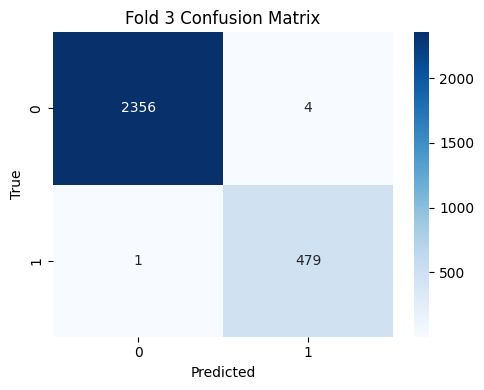

[FOLD 3] Metrics: acc=0.9982, prec=0.9917, rec=0.9979, spec=0.9983, f1=0.9948, auc=0.9997

[FOLD 4/5] Building fold data...
[FOLD 4] Train size: 11360 | Val size: 2840
[FOLD 4] Train class count (pre-balance): (array([0, 1], dtype=int32), array([9440, 1920]))
[FOLD 4] Val   class count:              (array([0, 1], dtype=int32), array([2360,  480]))
[FOLD 4] Computing normalization stats from TRAIN only...
[FOLD 4] ✅ Normalization done.
[FOLD 4] Preparing data for SMOTE (flatten to 2D)...
[FOLD 4] ✅ Class count BEFORE SMOTE: {0: 9440, 1: 1920}
[FOLD 4] ✅ SMOTE applied (k_neighbors=5).
[FOLD 4] ✅ Class count AFTER balancing (2D): {0: 9440, 1: 9440}
[FOLD 4] Reshaping back to CNN format...
[FOLD 4] ✅ Class count AFTER balancing (final): {0.0: 9440, 1.0: 9440}
[FOLD 4] X_train_bal shape: (18880, 61, 100, 1)
[FOLD 4] Building model...
[FOLD 4] Model compiled. Initial LR=0.0010000000474974513


Model: "EEGNet_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 61, 100, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 100, 16)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 61, 100, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_3              │ (None, 1, 100, 32)     │         1,952 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1, 100, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 1, 100, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 1, 25, 32)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 25, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 1, 25, 16)      │         1,024 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1, 25, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 1, 25, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_7             │ (None, 1, 3, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,457 (29.13 KB)

 Trainable params: 7,329 (28.63 KB)

 Non-trainable params: 128 (512.00 B)

None
[FOLD 4] Training started...
Epoch 1/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.5898 - loss: 0.6650
Epoch 1: val_loss improved from inf to 0.69091, saving model to fold_04_best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 27s 263ms/step - accuracy: 0.5902 - loss: 0.6647 - val_accuracy: 0.5616 - val_loss: 0.6909 - learning_rate: 0.0010
Epoch 2/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.7219 - loss: 0.5532
Epoch 2: val_loss did not improve from 0.69091
95/95 ━━━━━━━━━━━━━━━━━━━━ 25s 258ms/step - accuracy: 0.7219 - loss: 0.5531 - val_accuracy: 0.3377 - val_loss: 0.8307 - learning_rate: 0.0010
Epoch 3/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.7725 - loss: 0.4910
Epoch 3: val_loss improved from 0.69091 to 0.66987, savin

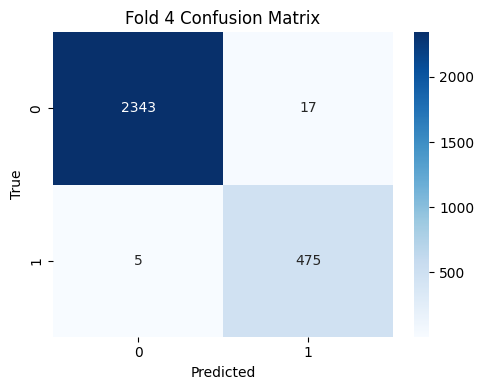

[FOLD 4] Metrics: acc=0.9923, prec=0.9654, rec=0.9896, spec=0.9928, f1=0.9774, auc=0.9991

[FOLD 5/5] Building fold data...
[FOLD 5] Train size: 11360 | Val size: 2840
[FOLD 5] Train class count (pre-balance): (array([0, 1], dtype=int32), array([9440, 1920]))
[FOLD 5] Val   class count:              (array([0, 1], dtype=int32), array([2360,  480]))
[FOLD 5] Computing normalization stats from TRAIN only...
[FOLD 5] ✅ Normalization done.
[FOLD 5] Preparing data for SMOTE (flatten to 2D)...
[FOLD 5] ✅ Class count BEFORE SMOTE: {0: 9440, 1: 1920}
[FOLD 5] ✅ SMOTE applied (k_neighbors=5).
[FOLD 5] ✅ Class count AFTER balancing (2D): {0: 9440, 1: 9440}
[FOLD 5] Reshaping back to CNN format...
[FOLD 5] ✅ Class count AFTER balancing (final): {0.0: 9440, 1.0: 9440}
[FOLD 5] X_train_bal shape: (18880, 61, 100, 1)
[FOLD 5] Building model...
[FOLD 5] Model compiled. Initial LR=0.0010000000474974513


Model: "EEGNet_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 61, 100, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 100, 16)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 61, 100, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_4              │ (None, 1, 100, 32)     │         1,952 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 1, 100, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 1, 100, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_8             │ (None, 1, 25, 32)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 25, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 1, 25, 16)      │         1,024 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 1, 25, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 1, 25, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_9             │ (None, 1, 3, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,457 (29.13 KB)

 Trainable params: 7,329 (28.63 KB)

 Non-trainable params: 128 (512.00 B)

None
[FOLD 5] Training started...
Epoch 1/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.5761 - loss: 0.6738
Epoch 1: val_loss improved from inf to 0.70699, saving model to fold_05_best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 26s 252ms/step - accuracy: 0.5766 - loss: 0.6735 - val_accuracy: 0.4539 - val_loss: 0.7070 - learning_rate: 0.0010
Epoch 2/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.7207 - loss: 0.5603
Epoch 2: val_loss improved from 0.70699 to 0.69807, saving model to fold_05_best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 24s 251ms/step - accuracy: 0.7209 - loss: 0.5601 - val_accuracy: 0.5229 - val_loss: 0.6981 - learning_rate: 0.0010
Epoch 3/300
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.7980 - loss: 0.4495
Epoch 3: va

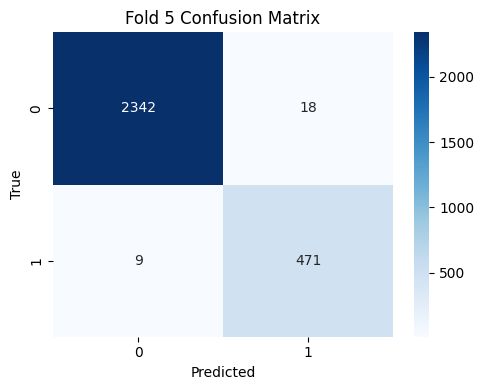

[FOLD 5] Metrics: acc=0.9905, prec=0.9632, rec=0.9812, spec=0.9924, f1=0.9721, auc=0.9988

[STEP 10] Cross-validation finished.

[FINAL] Average CV metrics (mean ± std):
  val_loss    : 0.0268 ± 0.0089
  val_acc     : 0.9927 ± 0.0032
  accuracy    : 0.9927 ± 0.0032
  precision   : 0.9733 ± 0.0119
  recall      : 0.9842 ± 0.0087
  specificity : 0.9945 ± 0.0025
  f1          : 0.9787 ± 0.0092
  auc         : 0.9985 ± 0.0012

[FINAL] Sum of confusion matrices across folds:
[[11735    65]
 [   38  2362]]


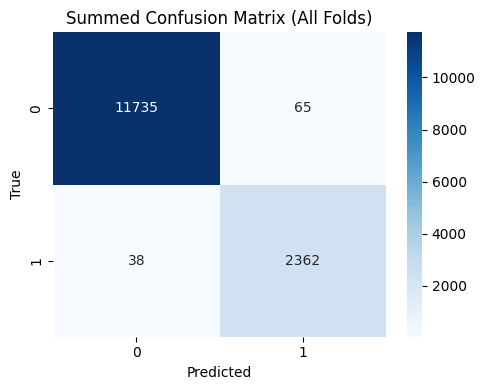

In [11]:
# %% Step 10 - 10-fold (or 5-fold) CV + per-fold normalization + SMOTE + per-fold metrics + averages

print("[STEP 10] Starting cross-validation...")  # log

n_splits = 5  # number of folds (change to 10 if you want)
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)  # stratified CV splitter

# Containers for fold results
fold_metrics = []  # store metrics dict per fold
fold_conf_mats = []  # store confusion matrix per fold

# Convenience variables
n_electrodes = X_all.shape[1]  # number of electrodes
segment_size = X_all.shape[2]  # segment length
input_shape = (n_electrodes, segment_size, 1)  # model input shape

print("[STEP 10] Input shape:", input_shape)  # log
print("[STEP 10] Global class count (before CV):", np.unique(y_all, return_counts=True))  # log

for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y_all), start=1):  # loop folds
    print("\n" + "=" * 70)  # separator
    print(f"[FOLD {fold}/{n_splits}] Building fold data...")  # header

    # ---------------- Split data ----------------
    X_train_raw = X_all[train_idx].astype(np.float32, copy=False)  # training samples
    y_train_raw = y_all[train_idx].astype(np.int32, copy=False)  # training labels
    X_val_raw = X_all[val_idx].astype(np.float32, copy=False)  # validation samples
    y_val_raw = y_all[val_idx].astype(np.int32, copy=False)  # validation labels

    print(f"[FOLD {fold}] Train size: {X_train_raw.shape[0]} | Val size: {X_val_raw.shape[0]}")  # sizes
    print(f"[FOLD {fold}] Train class count (pre-balance): {np.unique(y_train_raw, return_counts=True)}")  # counts
    print(f"[FOLD {fold}] Val   class count:              {np.unique(y_val_raw, return_counts=True)}")  # counts

    # ---------------- Normalization (TRAIN stats only) ----------------
    print(f"[FOLD {fold}] Computing normalization stats from TRAIN only...")  # log

    epsilon = 1e-6  # avoid division by zero
    train_mean = np.mean(X_train_raw, axis=(0, 2, 3), keepdims=True).astype(np.float32)  # mean per electrode
    train_std = np.std(X_train_raw, axis=(0, 2, 3), keepdims=True).astype(np.float32)  # std per electrode
    train_std = np.maximum(train_std, epsilon).astype(np.float32)  # clamp std

    X_train_norm = ((X_train_raw - train_mean) / train_std).astype(np.float32)  # normalized train
    X_val_norm = ((X_val_raw - train_mean) / train_std).astype(np.float32)  # normalized val

    print(f"[FOLD {fold}] ✅ Normalization done.")  # log

    # ---------------- SMOTE balancing (TRAIN ONLY) ----------------
    print(f"[FOLD {fold}] Preparing data for SMOTE (flatten to 2D)...")  # log

    X_train_2d = X_train_norm.reshape(X_train_norm.shape[0], -1)  # flatten (N, features)

    # Print class count BEFORE SMOTE
    unique_before, counts_before = np.unique(y_train_raw, return_counts=True)  # counts
    print(f"[FOLD {fold}] ✅ Class count BEFORE SMOTE: {dict(zip(unique_before.tolist(), counts_before.tolist()))}")  # log

    # Decide if SMOTE can run safely
    minority_n = int(np.min(counts_before))  # smallest class size

    if minority_n >= 2:  # SMOTE requires at least 2 minority samples
        k_neighbors = max(1, min(5, minority_n - 1))  # safe k_neighbors
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors)  # SMOTE object
        X_train_bal_2d, y_train_bal_int = smote.fit_resample(X_train_2d, y_train_raw)  # apply SMOTE
        print(f"[FOLD {fold}] ✅ SMOTE applied (k_neighbors={k_neighbors}).")  # log
    else:
        ros = RandomOverSampler(random_state=42)  # fallback oversampler
        X_train_bal_2d, y_train_bal_int = ros.fit_resample(X_train_2d, y_train_raw)  # apply fallback
        print(f"[FOLD {fold}] ⚠️ SMOTE not possible (minority_n={minority_n}); used RandomOverSampler.")  # log

    # Print class count AFTER balancing (2D stage)
    unique_after, counts_after = np.unique(y_train_bal_int, return_counts=True)  # counts
    print(f"[FOLD {fold}] ✅ Class count AFTER balancing (2D): {dict(zip(unique_after.tolist(), counts_after.tolist()))}")  # log

    # Reshape back to CNN format
    print(f"[FOLD {fold}] Reshaping back to CNN format...")  # log
    X_train_bal = X_train_bal_2d.reshape(-1, n_electrodes, segment_size, 1).astype(np.float32)  # reshape
    y_train_bal = y_train_bal_int.astype(np.float32)  # keras labels float32

    # Print class count AFTER balancing (final stage)
    unique_after2, counts_after2 = np.unique(y_train_bal, return_counts=True)  # counts
    print(f"[FOLD {fold}] ✅ Class count AFTER balancing (final): {dict(zip(unique_after2.tolist(), counts_after2.tolist()))}")  # log
    print(f"[FOLD {fold}] X_train_bal shape: {X_train_bal.shape}")  # shape log

    # Prepare val labels for keras
    y_val_float = y_val_raw.astype(np.float32, copy=False)  # float labels

    # ---------------- Build model ----------------
    print(f"[FOLD {fold}] Building model...")  # log
    model = create_eegnet(input_shape=input_shape, dropout_rate=0.5, num_classes=1)  # EEGNet

    model.compile(
        optimizer=Adam(learning_rate=1e-3),  # optimizer
        loss=BinaryCrossentropy(from_logits=False),  # loss
        metrics=[BinaryAccuracy(name='accuracy', threshold=0.5)]  # metric
    )

    print(f"[FOLD {fold}] Model compiled. Initial LR={get_lr(model.optimizer)}")  # log
    print(model.summary())  # print summary

    # ---------------- Callbacks ----------------
    lr_scheduler = ReduceLROnPlateau(monitor="loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)  # LR schedule
    early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)  # early stop
    ckpt = ModelCheckpoint(
        filepath=f"fold_{fold:02d}_best_model.keras",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )  # checkpoint
    csv_logger = CSVLogger(f"fold_{fold:02d}_training_log.csv", append=False)  # csv log

    callbacks = [lr_scheduler, early_stop, ckpt, csv_logger]  # callback list

    # ---------------- Train ----------------
    EPOCHS = 300  # epochs
    BATCH_SIZE = 200  # batch

    print(f"[FOLD {fold}] Training started...")  # log
    history = model.fit(
        X_train_bal, y_train_bal,
        validation_data=(X_val_norm, y_val_float),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=True,
        verbose=1,
        callbacks=callbacks
    )
    print(f"[FOLD {fold}] ✅ Training finished.")  # log
    print(f"[FOLD {fold}] Best val_loss={float(np.min(history.history['val_loss'])):.6f}")  # log

    # ---------------- Evaluate ----------------
    print(f"[FOLD {fold}] Evaluating on validation fold...")  # log
    val_loss, val_acc = model.evaluate(X_val_norm, y_val_float, batch_size=BATCH_SIZE, verbose=1)  # evaluate
    print(f"[FOLD {fold}] val_loss={val_loss:.4f} | val_acc={val_acc:.4f}")  # log

    # Predict probabilities
    print(f"[FOLD {fold}] Predicting probabilities on validation fold...")  # log
    y_prob = model.predict(X_val_norm, batch_size=BATCH_SIZE, verbose=1).reshape(-1)  # probs
    y_pred = (y_prob > 0.5).astype(int)  # binary preds

    # Confusion matrix
    cm = confusion_matrix(y_val_raw, y_pred)  # compute CM
    fold_conf_mats.append(cm)  # store CM
    print(f"[FOLD {fold}] Confusion matrix:\n{cm}")  # print CM

    # Extract TN, FP, FN, TP safely
    if cm.shape == (2, 2):
        TN, FP = int(cm[0, 0]), int(cm[0, 1])
        FN, TP = int(cm[1, 0]), int(cm[1, 1])
    else:
        TN = FP = FN = TP = 0  # fallback

    # Metrics
    accuracy = (TP + TN) / max((TP + TN + FP + FN), 1)
    precision = TP / max((TP + FP), 1)
    recall = TP / max((TP + FN), 1)
    specificity = TN / max((TN + FP), 1)
    f1 = (2 * precision * recall) / max((precision + recall), 1e-12)

    # AUC (guard)
    try:
        auc_val = float(roc_auc_score(y_val_raw, y_prob))
    except Exception:
        auc_val = float("nan")
        print(f"[FOLD {fold}] ⚠️ AUC could not be computed (likely single-class y_val).")

    # Store fold metrics
    fold_metrics.append({
        "fold": fold,
        "val_loss": float(val_loss),
        "val_acc": float(val_acc),
        "accuracy": float(accuracy),
        "precision": float(precision),
        "recall": float(recall),
        "specificity": float(specificity),
        "f1": float(f1),
        "auc": float(auc_val),
        "TN": TN, "FP": FP, "FN": FN, "TP": TP
    })

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Fold {fold} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # Fold summary
    print(f"[FOLD {fold}] Metrics: acc={accuracy:.4f}, prec={precision:.4f}, rec={recall:.4f}, "
          f"spec={specificity:.4f}, f1={f1:.4f}, auc={auc_val:.4f}")

print("\n" + "=" * 70)
print("[STEP 10] Cross-validation finished.")

# ---------------- Averages ----------------
def safe_mean(values):  # mean ignoring NaNs
    return float(np.nanmean(np.array(values, dtype=float)))

def safe_std(values):  # std ignoring NaNs
    return float(np.nanstd(np.array(values, dtype=float)))

avg_results = {
    "val_loss": safe_mean([m["val_loss"] for m in fold_metrics]),
    "val_acc": safe_mean([m["val_acc"] for m in fold_metrics]),
    "accuracy": safe_mean([m["accuracy"] for m in fold_metrics]),
    "precision": safe_mean([m["precision"] for m in fold_metrics]),
    "recall": safe_mean([m["recall"] for m in fold_metrics]),
    "specificity": safe_mean([m["specificity"] for m in fold_metrics]),
    "f1": safe_mean([m["f1"] for m in fold_metrics]),
    "auc": safe_mean([m["auc"] for m in fold_metrics]),
}

std_results = {
    "val_loss": safe_std([m["val_loss"] for m in fold_metrics]),
    "val_acc": safe_std([m["val_acc"] for m in fold_metrics]),
    "accuracy": safe_std([m["accuracy"] for m in fold_metrics]),
    "precision": safe_std([m["precision"] for m in fold_metrics]),
    "recall": safe_std([m["recall"] for m in fold_metrics]),
    "specificity": safe_std([m["specificity"] for m in fold_metrics]),
    "f1": safe_std([m["f1"] for m in fold_metrics]),
    "auc": safe_std([m["auc"] for m in fold_metrics]),
}

print("\n[FINAL] Average CV metrics (mean ± std):")
for k in avg_results.keys():
    print(f"  {k:12s}: {avg_results[k]:.4f} ± {std_results[k]:.4f}")

# Summed confusion matrix across folds
cm_sum = np.sum(np.stack(fold_conf_mats, axis=0), axis=0)
print("\n[FINAL] Sum of confusion matrices across folds:")
print(cm_sum)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_sum, annot=True, fmt="d", cmap="Blues")
plt.title("Summed Confusion Matrix (All Folds)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
